# Instalando bibliotecas

In [ ]:
""" Installing libraries """
%pip install --quiet pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0
%pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu129
Note: you may need to restart the kernel to use updated packages.


# Importando bibliotecas (externas e próprias)

In [3]:
""" Importing libraries """

import sys
import os

# Add the parent directory to sys.path so 'Modules' can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Our modules
from Modules.loading.read_parquet import read_parquet_file 
from Modules.preprocessing.onehot import one_hot_encode_parquet
from Modules.models.make_dataset import SingleSeriesDataset, MultiSeriesDataset
from Modules.models.NBeats import NBeatsBlock, NBeats
from Modules.models.WMAPELoss import WMAPELoss
from Modules.models.training import train_model
from Modules.models.test import soft_test
from Modules.models.test import hard_test
from Modules.models.forecast import forecast_blind
from Modules.loading.plug_n_play import get_clean_data

# Definição dos hiper-parâmetros

In [4]:
""" Defining hyper-parameters """
# Neural Network Global Parameters
input_size = 30  # Number of past days to use as input
output_size = 7  # Number of future days to predict
batch_size = 28  # Batch size for training

n_layers = 4  # Number of layers in the N-BEATS model
hidden_size = 128  # Number of hidden units in each layer

# Training parameters
learning_rate = 1e-3 # Learning rate for the optimizer
epochs = 100  # Number of training epochs (iterations over the entire dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
blind_horizon = 4  # Number of days to exclude from the end of the training set for hard test
split = 1 # Proportion of data to use for training (1.0 for validation)
seed = 42 # Random seed for reproducibility

device

device(type='cuda')

# Importação do Dataset

É interessante dividir o treino em batches (mini-conjuntos de treino). Cada batch possui o tamanho de input size, seguindo a ordem cronológica de vendas dentro daquela janela de dias. No entanto, durante o treinamento é **ESSENCIAL** que a escolha do próximo batch seja aleatória.

Ex.: Inicia o treino por 21-27 jul e prevê 28, depois pula para 02-08 fev para prever 03. Esse processo deve ser repetido até todos os dados serem treinados, finalizando **01 epoch**.

O número de **epochs** diz o número total de iterações do modelo com relação ao dataset inteiro.

Sobre a composição da janela de input dentro de um batch, existem duas abordagens:

1) Treinar em cada janela todas as séries (pense que cada par produto-loja x tempo representa uma série temporal dentro daquele período). Esse modelo é bem mais complexo pois o output deve ter o mesmo tamanho de produto-loja.
2) Treinar vários modelos separados (considerando uma série temporal para cada modelo). Esse método é ineficiente pois o modelo nunca irá aprender os padrões entre as séries.
3) Treinar o modelo com um par produto-loja por vez. Ou seja:
   - O modelo realiza epochs = N iterações de treino ao longo de todo dataset
     - Em cada epoch, passa por todas as M batches
       - Em cada batch (que possui uma janela de tamanho input_size), atualiza os parâmetros para cada série temporal ($x_l,y_l$). Totalizando L atualizações, com L sendo o número de pares produto-loja.

Ressalta-se que cada conjunto ($x_l,y_l$) representa:
- $x_l$: série temporal do l-ésimo par produto-loja, sendo um vetor de tamanho input_size x (features + 1)
- $y_l$: Previsão de vendas do l-ésimo par produto-loja para os próximos $output_size$ dias


In [5]:
# Recebe os dados filtrados / limpos
clean_data = get_clean_data(verbose=True)

00:00:063 FILE_PATHS
00:00:000 loaded_data
00:01:607 numerical_table
00:00:544 outlierless
00:00:777 pivoted_df
00:12:320 rescaled_df
00:07:762 copying
00:00:845 returning


In [ ]:

def get_sample(clean_data, col):
    return clean_data[clean_data.sum().sort_values(ascending=True).index[-1]].values

def get_predictions(sample, hyperparams):


    return prediction, predicted_col 

In [29]:
hyperparams = {
    'input_size': input_size,
    'output_size': output_size,
    'batch_size': batch_size,
    'n_layers': n_layers,
    'hidden_size': hidden_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'device': device,
    'blind_horizon': blind_horizon,
    'split': split,
    'seed': seed
}

#prediction, 
sample = get_sample(clean_data, 1)
predicted_col = get_predictions(sample, hyperparams)


NameError: name 'get_sample' is not defined

<BarContainer object of 365 artists>

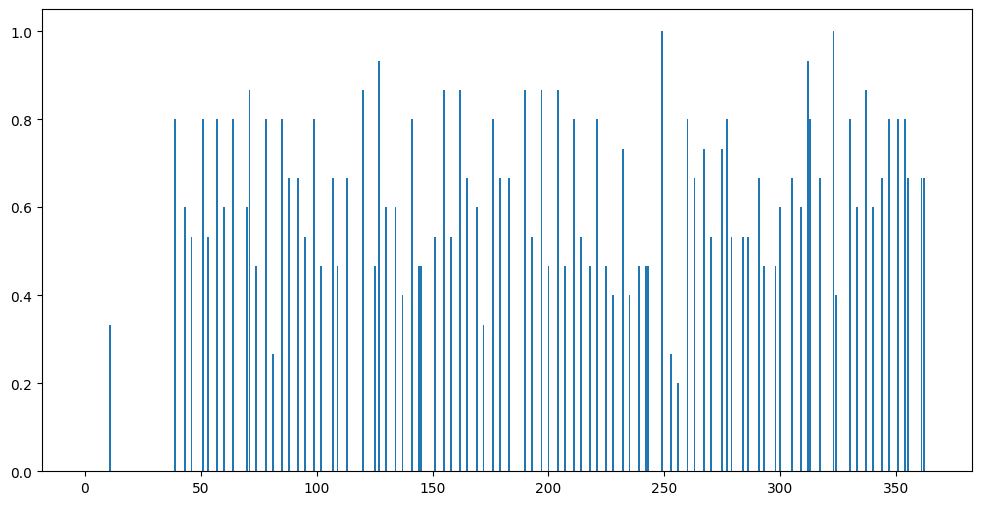

In [17]:
# Teste de uma série qualquer
sum_df = clean_data.sum().sort_values(ascending=True)
test_sample = clean_data[sum_df.index[-1]].values

plt.figure(figsize=(12, 6))
plt.bar(range(len(clean_data)), test_sample)

# Transformando o Dataframe em um Dataset



In [7]:
# Admissão de um sample para teste univariado
sample = test_sample

# Criação de um feature básico, de diferença entre dados consecutivos 
feature_1 = [sample[t] - sample[t-1] for t in range(1, len(sample))]

# Normalização dos dados para a faixa [0, 1] - MÉTODO SIMPLES, PESQUISAR OUTROS
sample = (test_sample - np.min(test_sample)) / (np.max(test_sample) - np.min(test_sample))
feature_1 = (feature_1 - np.min(feature_1)) / (np.max(feature_1) - np.min(feature_1))



In [8]:
# Inicializando os vetores de entrada e os rótulos
X = []
y = []

# Número total de amostras (janelas diferentes) que podem ser extraídas
# de um mesmo sample
num_windows = len(sample) - input_size - output_size + 1
print(f"Número total de janelas extraídas: {num_windows}")
print(f"Para janelas de tamanho {input_size} e previsão de {output_size} dias à frente.")
# Extraindo janelas deslizantes
for i in range(num_windows):

    X_window = sample[i:i+input_size]             # janela de entrada
    feature_1_window = feature_1[i:i+input_size]      # janela de entrada

    X_window = np.stack([X_window,feature_1_window], axis=1)  # shape = (input_size, 4)

    y_window = sample[i+input_size:i+input_size+output_size]  # próximos dias da série

    X.append(X_window)
    y.append(y_window)

# Convertendo para arrays numpy e depois para tensores PyTorch
X = np.array(X)  # shape = [num_windows, input_size, num_features]
y = np.array(y)  # shape = [num_windows, output_size]
print()
print("O vetor de entrada  antes do flatten")
print(f"tem shape (num_windows, size_window, num_features): {X.shape}")

X = torch.tensor(X, dtype=torch.float32)  # shape = [n_samples, input_size, 1]

y = torch.tensor(y, dtype=torch.float32)  # shape = [n_samples, 1]


dataset_full = SingleSeriesDataset(X, y)


Número total de janelas extraídas: 329
Para janelas de tamanho 30 e previsão de 7 dias à frente.

O vetor de entrada  antes do flatten
tem shape (num_windows, size_window, num_features): (329, 30, 2)


# Separando os dados entre treino / validação

Os dados serão separados na proporção 80% - treino / 20% validação. Para séries temporais, é usual que essa separação seja feita de forma cronológica

In [9]:
# Ponto de separação entre treino e validação (Caso seja para envio, não há validação)
if split < 1:
    split_point = int(split * len(dataset_full))
    # Separação cronológica das janelas
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
else:
    X_train = X
    y_train = y

num_features = X_train.shape[2]

# Flatten do tensor para entrar na rede
X_train = X_train.view(X_train.shape[0], -1)  # shape = [num_windows_train, input_size * n_features]

if split < 1:
    X_test  = X_test.view(X_test.shape[0], -1) # shape = [num_windows_test, input_size * n_features]

print(f"Há um total de {len(dataset_full)} janelas e o split ocorre em {split*100:.0f}% do dataset")
print(f" O shape de X_train é {X_train.shape} e o shape de X_test é {X_test.shape}") if split < 1 else ""
print(f" O shape de y_train é {y_train.shape} e o shape de y_test é {y_test.shape}") if split < 1 else ""

Há um total de 329 janelas e o split ocorre em 100% do dataset


''

# Treinamento

In [10]:
# Adotando o dataset de treino
dataset = SingleSeriesDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

# Inicialização do modelo N-BEATS (considerando X_train com num_features)
model = NBeats(input_size * num_features, hidden_size, output_size, n_layers).to(device)

model, criterion, optimizer = train_model(model, learning_rate, epochs, device, dataloader)




Epoch 1/100, Loss: 1.2585
Epoch 2/100, Loss: 1.1130
Epoch 3/100, Loss: 1.0969
Epoch 4/100, Loss: 1.0707
Epoch 5/100, Loss: 1.0505
Epoch 6/100, Loss: 1.0523
Epoch 7/100, Loss: 1.0525
Epoch 8/100, Loss: 1.0154
Epoch 9/100, Loss: 1.0145
Epoch 10/100, Loss: 1.0173
Epoch 11/100, Loss: 1.0131
Epoch 12/100, Loss: 1.0010
Epoch 13/100, Loss: 0.9898
Epoch 14/100, Loss: 0.9763
Epoch 15/100, Loss: 0.9625
Epoch 16/100, Loss: 0.9418
Epoch 17/100, Loss: 0.9237
Epoch 18/100, Loss: 0.8844
Epoch 19/100, Loss: 0.8615
Epoch 20/100, Loss: 0.8396
Epoch 21/100, Loss: 0.8209
Epoch 22/100, Loss: 0.8016
Epoch 23/100, Loss: 0.7951
Epoch 24/100, Loss: 0.7974
Epoch 25/100, Loss: 0.7936
Epoch 26/100, Loss: 0.7550
Epoch 27/100, Loss: 0.7283
Epoch 28/100, Loss: 0.7035
Epoch 29/100, Loss: 0.6967
Epoch 30/100, Loss: 0.6849
Epoch 31/100, Loss: 0.6977
Epoch 32/100, Loss: 0.7160
Epoch 33/100, Loss: 0.7294
Epoch 34/100, Loss: 0.6880
Epoch 35/100, Loss: 0.6917
Epoch 36/100, Loss: 0.6644
Epoch 37/100, Loss: 0.6524
Epoch 38/1

# Sanity check do modelo treinado

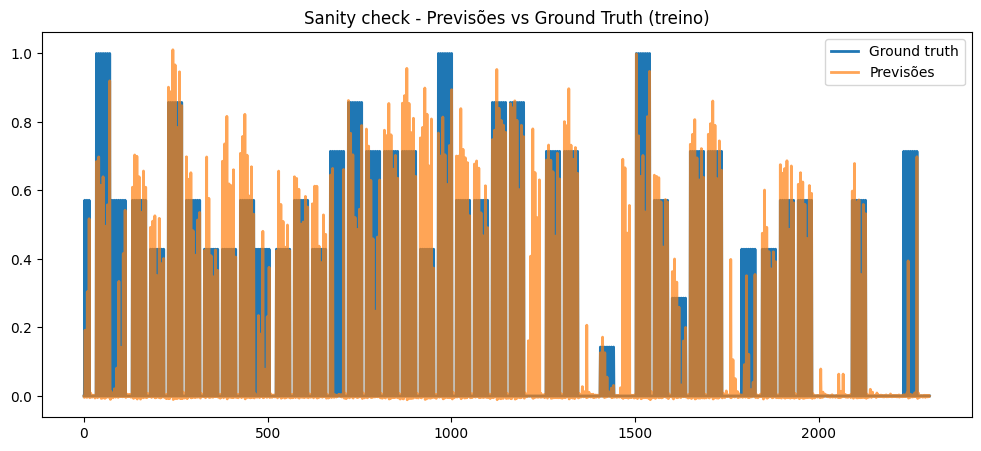

In [11]:
def sanity_check_plot(model, dataloader, device, output_size):
    """
    Plota previsões vs ground truth no período de treino
    """
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            preds = model(x)
            
            # Se seu modelo retorna (batch, output_size)
            preds = preds.cpu().numpy().flatten()
            y = y.cpu().numpy().flatten()

            all_preds.extend(preds)
            all_targets.extend(y)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(all_targets, label="Ground truth", linewidth=2)
    plt.plot(all_preds, label="Previsões", linewidth=2, alpha=0.7)
    plt.title("Sanity check - Previsões vs Ground Truth (treino)")
    plt.legend()
    plt.show()

sanity_check_plot(model, dataloader, device, output_size)

In [12]:
y

tensor([[0.0000, 0.0000, 0.5714,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5714, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5714, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

# Validação do modelo

São feitos dois testes:

- **Soft test:** Modelo  tenta fazer as previsões, mas não utiliza-as nas previsões futuras, utiliza sempre os *ground truth* como input
- **Hard test:** Modelo tenta fazer as previsões, e utiliza $y_{i-1}$ para a previsão de $y_i$

In [13]:
" Validando o modelo quando o split é menor que 1"
if split < 1:
    # Adotando o dataset de validação (soft)
    dataset = SingleSeriesDataset(X_test, y_test)
    dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

    all_preds_S, all_targets_S, avg_loss_test_S = soft_test(model, dataloader, device, criterion)

    # Validação hard - previsão cega das primeiras blind_horizon semanas
    all_preds_H, all_targets_H, avg_loss_test_H = hard_test(model, X_train, y_train, y_test, split_point, device, criterion, blind_horizon, output_size)

    " Sanity check da validação do modelo (preds and targets)"
    all_preds_array = []
    all_targets_array = []

    # Convert lists to tensors before flattening
    all_preds_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_preds_H], dim=0).flatten()
    all_targets_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_targets_H], dim=0).flatten()

    for t in all_preds_tensor:
        all_preds_array.append(t.detach().numpy())
    for t in all_targets_tensor:
        all_targets_array.append(t.detach().numpy())


    plt.figure(figsize=(12, 5))
    plt.plot(all_targets_array, label="Ground truth", linewidth=2)
    plt.plot(all_preds_array, label="Previsões", linewidth=2, alpha=0.7)
    plt.legend()


# Previsão cega (quando split == 1)

Previsão para envio para o hackathon das 4 primeiras semanas de janeiro/23. Utiliza todo o dataset como treino.

In [14]:
preds_blind = forecast_blind(model, X_train, blind_horizon, device, output_size) if split == 1.0 else print("Previsão cega não realizada, pois split < 1.0")
print(preds_blind)

preview_next_year = [i for i in preds_blind.detach().cpu().numpy()]
print(preview_next_year)

tensor([ 1.6913e-03, -2.7858e-03, -2.5470e-03,  1.7060e-03, -8.9230e-04,
        -1.7445e-03, -9.5211e-05, -2.8662e-02,  1.9025e-01, -3.7857e-02,
         2.3026e-01,  2.0077e-01, -1.8161e-02,  4.9814e-01, -1.2387e-03,
         5.1884e-02, -3.3694e-04,  2.1344e-03, -8.9357e-04, -3.4625e-03,
         1.1010e-03, -3.2658e-02,  1.3997e-01, -3.9142e-02,  3.0104e-01,
         1.9080e-01, -1.8650e-02,  1.6632e-01], device='cuda:0',
       grad_fn=<CatBackward0>)
[np.float32(0.0016912911), np.float32(-0.002785813), np.float32(-0.002547036), np.float32(0.0017059743), np.float32(-0.00089229643), np.float32(-0.0017445013), np.float32(-9.521097e-05), np.float32(-0.028661719), np.float32(0.19024639), np.float32(-0.03785714), np.float32(0.2302556), np.float32(0.20076588), np.float32(-0.01816072), np.float32(0.4981353), np.float32(-0.0012387484), np.float32(0.05188439), np.float32(-0.0003369404), np.float32(0.002134392), np.float32(-0.0008935686), np.float32(-0.0034625195), np.float32(0.001100976), 

In [ ]:
from Modules.evaluation.output_formatter import forecast_to_output

predicted_col = ('1234', '4321')

final_df = forecast_to_output(prediction, predicted_col)  # Exemplo de uso
final_df

,semana,pdv,produto,quantidade
0,1,1234,4321,0
1,2,1234,4321,2
2,3,1234,4321,1
3,4,1234,4321,1


# Ponto de parada - RAB 18-09-25
- Temporais (mais fáceis de pensar e implementar)
- Categóricas (intrínsecas do produto ou da loja, como a categoria deles)
- De localização (apenas se der tempo)

Após termos feito isso, podemos então realizar normalização dos sinais, one hot encoding do que for viável e embedding de IDs etc